In [77]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import requests
import os
from cobra.io import load_model
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import single_gene_deletion

#Gens essencials
from cobra.core.gene import eval_gpr
from cobra.core.gene import GPR

#MFG
from scipy.linalg import pinv

#FPE
from scipy.linalg import eig
from sklearn.preprocessing import StandardScaler


#FLOWGAT
import torch_geometric


Eliminam l'enzim-reacció 3.2.1.21. 
No apareix a l'excel de l'article i hi apareixen lletres enlloc de nombres...

La següent passa és afegir la reacció de BIOMASSA segons l'excel de l'article. 

# MODEL iML1515

In [313]:
model_path = "iML1515.json"
model = cobra.io.load_json_model(model_path)
print(f"Model: {model.id}")
print(f"Number of reactions: {len(model.reactions)}")
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of genes: {len(model.genes)}")

Model: iML1515
Number of reactions: 2712
Number of metabolites: 1877
Number of genes: 1516


In [4]:
S = cobra.util.array.create_stoichiometric_matrix(model)
S_df = pd.DataFrame(S, 
                    index=[met.id for met in model.metabolites], 
                    columns=[rxn.id for rxn in model.reactions])
S_df.to_csv('iML1515_stoichiometry.csv')
print(f"Stoichiometric matrix dimensions: {S.shape}")
print(f"Number of metabolites: {S.shape[0]}")
print(f"Number of reactions: {S.shape[1]}")

Stoichiometric matrix dimensions: (1877, 2712)
Number of metabolites: 1877
Number of reactions: 2712


## Gens essencials (ground truth)
Amb el resultat del FBA, ara podem veure, amb un llindar del 0.05, quins gens són els essencials. 


In [154]:
essentials = pd.read_csv("essentials.csv")
essentials_df = pd.DataFrame({"ids": [set(essentials["Gene"])]})


### Flux Balance Analysis 

In [319]:
# Aerobic growth with glucose as sole carbon source: 
model.reactions.EX_glc__D_e.bounds = (-10, 0) 
model.reactions.EX_o2_e.bounds = (-20, 0)
model.reactions.ARAI.bounds = (0,1000)
model.reactions.RBK_L1.bounds = (0,1000)
model.reactions.RMPA.bounds = (0,0)
model.reactions.LYXI.bounds = (0,0)
model.reactions.RMI.bounds = (0,0)
model.reactions.RMK.bounds = (0,0)
model.reactions.LACZ.bounds = (0,0)

# Definim funció objectiu per a l'optimització
model.objective = 'BIOMASS_Ec_iML1515_core_75p37M'  

# FBA
solution = model.optimize()

#Vegem les solucions
print(f"Growth rate: {solution.objective_value}")

Growth rate: 0.8217979336265967


In [167]:
v = solution.fluxes
num_near_zero = np.sum(np.abs(v) > 1e-10)
num_near_zero

np.int64(434)

In [334]:
bounds_df = pd.DataFrame({
    'reaction': [r.id for r in model.reactions],
    'lower_bound': [r.lower_bound for r in model.reactions],
    'upper_bound': [r.upper_bound for r in model.reactions],
    'is_reversible': [reaction.lower_bound < 0 and reaction.upper_bound > 0 for reaction in model.reactions],
    'name': [r.name for r in model.reactions],    
    'flux': v
})
bounds_df.head(30)

# Merge with bounds_df to add essentiality labels
bounds_df = bounds_df.merge(reaction_essentials_df, on="reaction", how="left")
# Show the updated dataset
bounds_df.to_csv('bounds.csv')
bounds_df.head(15)

,reaction,lower_bound,upper_bound,is_reversible,name,flux,essentiality
0,CYTDK2,0.0,1000.0,False,Cytidine kinase (GTP),0.000000e+00,0
1,XPPT,0.0,1000.0,False,Xanthine phosphoribosyltransferase,0.000000e+00,0
2,HXPRT,0.0,1000.0,False,Hypoxanthine phosphoribosyltransferase (Hypoxa...,0.000000e+00,-1
3,NDPK5,-1000.0,1000.0,True,Nucleoside-diphosphate kinase (ATP:dGDP),4.518991e-16,-1
4,SHK3Dr,-1000.0,1000.0,True,Shikimate dehydrogenase,3.132028e-01,-1
5,NDPK6,-1000.0,1000.0,True,Nucleoside-diphosphate kinase (ATP:dUDP),0.000000e+00,-1
6,NDPK8,-1000.0,1000.0,True,Nucleoside-diphosphate kinase (ATP:dADP),5.749474e-16,-1
7,DHORTS,-1000.0,1000.0,True,Dihydroorotase,-2.718466e-01,1
8,OMPDC,0.0,1000.0,False,Orotidine-5'-phosphate decarboxylase,2.718466e-01,1
9,PYNP2r,-1000.0,1000.0,True,Pyrimidine-nucleoside phosphorylase (uracil),9.316738e-18,0


In [409]:
low_flux_reactions_df =  bounds_df[bounds_df["flux"].abs() > 1e-10]
low_flux_reactions = bounds_df[bounds_df["flux"].abs()> 1e-10]["reaction"].tolist()

# Get indices of selected reactions in the stoichiometric matrix
reaction_indices = [i for i, r in enumerate(bounds_df["reaction"]) if r in low_flux_reactions]

# Reduce S by selecting only the columns corresponding to low-flux reactions
S_reduced = S[:, reaction_indices]

# Create a DataFrame for better visualization
S_reduced_df = pd.DataFrame(S_reduced, columns=low_flux_reactions)

# Display the reduced stoichiometric matrix
#S_reduced_df.head()
low_flux_reactions_df
low_flux = low_flux_reactions_df[['flux']]

In [424]:
low_flux_reactions_df

,reaction,lower_bound,upper_bound,is_reversible,name,flux,essentiality
4,SHK3Dr,-1000.0,1000.0,True,Shikimate dehydrogenase,0.313203,-1
7,DHORTS,-1000.0,1000.0,True,Dihydroorotase,-0.271847,1
8,OMPDC,0.0,1000.0,False,Orotidine-5'-phosphate decarboxylase,0.271847,1
10,G5SD,0.0,1000.0,False,Glutamate-5-semialdehyde dehydrogenase,0.181663,1
11,CS,0.0,1000.0,False,Citrate synthase,5.280300,1
...,...,...,...,...,...,...,...
2625,TYRL,0.0,1000.0,False,Tyrosine lyase,0.000183,1
2629,THZPSN3,0.0,1000.0,False,Thiazole phosphate synthesis,0.000183,-1
2634,PAI2T,0.0,1000.0,False,"3-hydroxy-2,4-pentadione 5-phosphate thiolase",0.000368,0
2650,4HTHRK,0.0,1000.0,False,4-Hydroxy-L-threonine kinase,0.000550,1


### Estoiquimetria i reversibilitat

In [ ]:
S_sparse = sp.csr_matrix(S_df.values)
plt.figure(figsize=(10, 8))
plt.spy(S, markersize=0.8, color='blue')

### Gene-To-Protein Reaction (GPR)

In [333]:
reaction_essentials = assign_reaction_essentiality(model, essentials_df)
reaction_essentials_df = pd.DataFrame(reaction_essentials.items(), columns=["reaction", "essentiality"])
#reaction_essentials = {**reaction_essentials, **{k + "_r": v for k, v in reaction_essentials.items()}}

Processing 249 essential genes
Found 316 essential reactions, 986 non-essential reactions
1410 reactions marked as unknown


In [323]:
def assign_reaction_essentiality(model, essential_genes_df, low_flux_reactions=None):
    # Extract gene IDs from the DataFrame
    essential_genes_set = set()
    for gene_set in essential_genes_df['ids']:
        for gene_id in gene_set:
            essential_genes_set.add(gene_id)
    
    print(f"Processing {len(essential_genes_set)} essential genes")
    
    # If no low_flux_reactions specified, use all reactions
    if low_flux_reactions is None:
        low_flux_reactions = [r.id for r in model.reactions]
    
    # Dictionary to store essentiality results
    rxn_essentiality = {}
    essential_rxn_count = 0
    non_essential_rxn_count = 0
    
    # Process each reaction
    for rxn_id in low_flux_reactions:
        # Get the reaction object
        rxn = model.reactions.get_by_id(rxn_id)
        
        # Skip reactions without genes (spontaneous or exchange reactions)
        if not rxn.genes:
            rxn_essentiality[rxn.id] =-1
           
            continue
        
         # ONE-TO-ONE // ONE-TO-MANY
        if len(rxn.genes) == 1:
            gene = list(rxn.genes)[0]
            if gene.id in essential_genes_set:
                rxn_essentiality[rxn.id] = 1
                essential_rxn_count += 1
            
            else:
                rxn_essentiality[rxn.id] = 0
                non_essential_rxn_count += 1
            
        else:
            '''
            # If multiple genes, check if at least one is essential
            essential_gene_found = any(gene.id in essential_genes_set for gene in rxn.genes)

            if essential_gene_found:
                rxn_essentiality[rxn.id] = 1  
                essential_rxn_count += 1
            else: 
                rxn_essentiality[rxn.id] = 0  # None of the genes are essential → Non-essential
                non_essential_rxn_count += 1
            '''
            rxn_essentiality[rxn.id] =-1  
                           
    print(f"Found {essential_rxn_count} essential reactions, {non_essential_rxn_count} non-essential reactions")
    print(f"{len(low_flux_reactions) - essential_rxn_count - non_essential_rxn_count} reactions marked as unknown")
    
    return rxn_essentiality

low_flux_essentials = assign_reaction_essentiality(model, essentials_df, low_flux_reactions)

Processing 249 essential genes
Found 185 essential reactions, 66 non-essential reactions
183 reactions marked as unknown


In [371]:
# Get reaction IDs from the reduced matrix
low_flux_reactions = S_reduced_df.columns.tolist()

# Apply the function to get essentiality labels
low_flux_essentiality = assign_reaction_essentiality(model, essentials_df, low_flux_reactions)

# Convert to a DataFrame
low_flux_essentiality_df = pd.DataFrame(
    list(low_flux_essentiality.items()), columns=["reaction", "essentiality"]
)

# Merge with the full dataset (S_reduced_df) to keep all reaction information
complete_dataset = S_reduced_df.T.reset_index().rename(columns={"index": "reaction"})  # Transpose and reset index
complete_dataset = complete_dataset.merge(low_flux_essentiality_df, on="reaction", how="left")

# Show a preview
print(complete_dataset.head(20))

# Save the dataset for further use
complete_dataset.to_csv("low_flux_essentiality_dataset.csv", index=False)


Processing 249 essential genes
Found 185 essential reactions, 66 non-essential reactions
183 reactions marked as unknown
    reaction    0    1    2    3    4    5    6    7    8  ...  1868  1869  \
0     SHK3Dr  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
1     DHORTS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
2      OMPDC  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
3       G5SD  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
4         CS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
5     ICDHyr  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
6        PPA  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
7     APRAUR  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
8     TRPAS2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
9      DB4PS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
10      ALAR  0.0  0.

# Mass Flow Graph (MFG)
Anem amb la construcció del MFG. 

In [416]:
flux_array = low_flux['flux'].to_numpy()  # or df['flux'].values for older pandas versions

In [418]:
len(flux_array)

434

In [425]:
def compute_mfg_with_labels(S_df, fba_solution):
    # Extract the stoichiometric matrix and reaction labels
    reaction_labels = S_df.columns.tolist()
    metabolite_labels = S_df.index.tolist()
    S = S_df.values
    
    # Get dimensions
    n_metabolites, n_reactions = S.shape
    
    # Unfold the FBA solution into forward and reverse reactions
    v_star = np.array(fba_solution)
    v_star_2m = np.concatenate([
        0.5 * (np.abs(v_star) + v_star),
        0.5 * (np.abs(v_star) - v_star)
    ])
    
    # Create label list for unfolded reactions
    unfolded_labels = []
    for label in reaction_labels:
        unfolded_labels.append(f"{label}_forward")
        unfolded_labels.append(f"{label}_reverse")
    
    # Construct the unfolded stoichiometric matrix
    I_m = np.eye(n_reactions)
    
    r = np.ones(n_reactions)  
    #r = np.array([1 if r.lower_bound < 0 else 0 for r in model.reactions])
    r = np.array(low_flux_reactions_df['is_reversible'].astype(int)) 
    diag_r = np.diag(r)
    print(f"I_m shape: {I_m.shape}")
    print(f"Zeros shape: {np.zeros((n_reactions, n_reactions)).shape}")
    print(f"diag_r shape: {diag_r.shape}")
    block_matrix = np.block([
        [I_m, np.zeros((n_reactions, n_reactions))],
        [np.zeros((n_reactions, n_reactions)), diag_r]
    ])
    
    S_2m = np.dot(np.hstack([S, -S]), block_matrix)
    
    # Calculate production and consumption matrices
    S_plus_2m = 0.5 * (np.abs(S_2m) + S_2m)
    S_minus_2m = 0.5 * (np.abs(S_2m) - S_2m)
    
    # Calculate the diagonal matrix of fluxes
    V_star = np.diag(v_star_2m)
    
    # Calculate the flux of each metabolite
    j_v_star = np.dot(S_plus_2m, v_star_2m)
    
    # Create a diagonal matrix for the inverse of j_v_star
    j_v_star_safe = np.where(j_v_star != 0, j_v_star, 1.0)  # Replace zeros with 1
    J_v_star = np.diag(1.0 / j_v_star_safe)
    
    # Calculate the MFG adjacency matrix
    S_plus_2m_V = np.dot(S_plus_2m, V_star)
    S_minus_2m_V = np.dot(S_minus_2m, V_star)
    
    M_v_star = np.dot(np.dot(S_plus_2m_V.T, J_v_star), S_minus_2m_V)
    
    # Create a DataFrame to maintain the labels
    mfg_df = pd.DataFrame(M_v_star, index=unfolded_labels, columns=unfolded_labels)
    
    # Identify the connected component
    # A node is connected if it has at least one non-zero entry in its row or column
    connected_mask = ((np.abs(M_v_star).sum(axis=0) > 1e-10) | (np.abs(M_v_star).sum(axis=1) > 1e-10))
    connected_indices = np.where(connected_mask)[0]
    
    # Check if there are any connected nodes
    if len(connected_indices) == 0:
        return {
            'full_mfg': mfg_df,
            'connected_mfg': pd.DataFrame(),
            'connected_labels': [],
            'original_connected_labels': []
        }
    
    # Extract the connected component subgraph with labels
    connected_labels = [unfolded_labels[i] for i in connected_indices]
    M_k = M_v_star[connected_indices, :][:, connected_indices]
    mfg_connected_df = pd.DataFrame(M_k, index=connected_labels, columns=connected_labels)
    
    # Map the connected reactions back to original reaction labels
    # Remove the "_forward" and "_reverse" suffixes
    original_connected_labels = []
    for label in connected_labels:
        if label.endswith("_forward"):
            original_connected_labels.append(label[:-8])
        elif label.endswith("_reverse"):
            original_connected_labels.append(label[:-8])
    
    # Remove duplicates to get unique reactions in the connected component
    original_connected_labels = list(set(original_connected_labels))
    
    return {
        'full_mfg': mfg_df,
        'connected_mfg': mfg_connected_df,
        'connected_labels': connected_labels,
        'original_connected_labels': original_connected_labels
    }

def extract_features(mfg_connected_df):
    M_k = mfg_connected_df.values
    M_k_transpose = M_k.T
    
    # Create feature matrix X = [M_k M_k']
    X = np.hstack([M_k, M_k_transpose])
    
    # Normalize features to unit variance (without centering)
    std = np.std(X, axis=0, keepdims=True)
    std[std == 0] = 1.0  # Avoid division by zero
    X_normalized = X / std
    
    # Create DataFrame with labels
    X_df = pd.DataFrame(
        X_normalized, 
        index=mfg_connected_df.index,
        columns=[f"outflow_{col}" for col in mfg_connected_df.columns] + 
                [f"inflow_{col}" for col in mfg_connected_df.columns]
    )
    
    return X_df

mfg_result = compute_mfg_with_labels(S_reduced_df, flux_array)

# The connected component of the MFG with labels
connected_mfg = mfg_result['connected_mfg']
X_features = extract_features(connected_mfg)
X_features

I_m shape: (434, 434)
Zeros shape: (434, 434)
diag_r shape: (434, 434)


,outflow_SHK3Dr_forward,outflow_DHORTS_forward,outflow_DHORTS_reverse,outflow_OMPDC_forward,outflow_OMPDC_reverse,outflow_G5SD_forward,outflow_G5SD_reverse,outflow_CS_reverse,outflow_ICDHyr_forward,outflow_ICDHyr_reverse,...,inflow_ACPPAT161_reverse,inflow_APG3PAT160_forward,inflow_APG3PAT160_reverse,inflow_APG3PAT161_forward,inflow_APG3PAT161_reverse,inflow_MEOHtex_forward,inflow_I2FE2SS_forward,inflow_I2FE2SS2_reverse,inflow_DM_4crsol_c_reverse,inflow_THZPSN3_reverse
SHK3Dr_forward,0.000000,0.000000,0.000000,0.0,0.475359,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
DHORTS_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
DHORTS_reverse,0.000000,0.000000,0.000000,0.0,0.275716,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
OMPDC_forward,0.258708,0.286727,0.258708,0.0,0.000000,0.0,0.258708,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
OMPDC_reverse,7.193559,0.000000,7.193559,0.0,0.000000,0.0,7.193559,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEOHtex_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
I2FE2SS_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
I2FE2SS2_reverse,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
DM_4crsol_c_reverse,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.808708,0.0,0.0


In [432]:
def map_essentiality_to_connected_mfg(mfg_result, essentiality_dict):
    connected_labels = mfg_result['connected_labels']
    essentiality_mapped = {}
    
    # First, create a map of base reactions to their essentiality
    base_reaction_essentiality = {}
    for label in connected_labels:
        if label.endswith("_forward"):
            # Extract original reaction name
            original_label = label[:-8]  # Remove "_forward" suffix
            if original_label in essentiality_dict:
                base_reaction_essentiality[original_label] = essentiality_dict[original_label]
    
    # Now map both forward and reverse reactions
    for label in connected_labels:
        if label.endswith("_forward"):
            original_label = label[:-8]
            essentiality_mapped[label] = base_reaction_essentiality.get(original_label, -1)
        elif label.endswith("_reverse"):
            original_label = label[:-8]
            essentiality_mapped[label] = base_reaction_essentiality.get(original_label, -1)
    
    return essentiality_mapped

# Then you can use this function with your feature extraction
def extract_features_with_labels(mfg_connected_df, essentiality_mapped):
    M_k = mfg_connected_df.values
    M_k_transpose = M_k.T
    
    # Create feature matrix X = [M_k M_k']
    X = np.hstack([M_k, M_k_transpose])
    
    # Normalize features to unit variance (without centering)
    std = np.std(X, axis=0, keepdims=True)
    std[std == 0] = 1.0  # Avoid division by zero
    X_normalized = X / std
    
    # Create DataFrame with features
    X_df = pd.DataFrame(
        X_normalized, 
        index=mfg_connected_df.index,
        columns=[f"outflow_{col}" for col in mfg_connected_df.columns] + 
                [f"inflow_{col}" for col in mfg_connected_df.columns]
    )
    
    # Add essentiality labels
    X_df['essentiality'] = X_df.index.map(lambda x: essentiality_mapped.get(x, -1))
    
    return X_df

essentiality_mapped = map_essentiality_to_connected_mfg(mfg_result, low_flux_essentials)

# Extract features and add essentiality labels
X_with_labels = extract_features_with_labels(mfg_result['connected_mfg'], essentiality_mapped)

In [435]:
X_with_labels[X_with_labels['essentiality'] == 0]

,outflow_SHK3Dr_forward,outflow_DHORTS_forward,outflow_DHORTS_reverse,outflow_OMPDC_forward,outflow_OMPDC_reverse,outflow_G5SD_forward,outflow_G5SD_reverse,outflow_CS_reverse,outflow_ICDHyr_forward,outflow_ICDHyr_reverse,...,inflow_APG3PAT160_forward,inflow_APG3PAT160_reverse,inflow_APG3PAT161_forward,inflow_APG3PAT161_reverse,inflow_MEOHtex_forward,inflow_I2FE2SS_forward,inflow_I2FE2SS2_reverse,inflow_DM_4crsol_c_reverse,inflow_THZPSN3_reverse,essentiality
PPM_forward,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
PPM_reverse,0.000000,0.000000,0.000000,0.026248,0.000000,0.055897,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
CPPPGO_forward,0.000000,0.000000,0.000000,0.000040,0.000000,0.000086,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
CPPPGO_reverse,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
PGI_forward,0.000027,0.000030,0.000027,0.000000,0.000000,0.000000,0.000027,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
PGI_reverse,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
PGL_forward,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
PGL_reverse,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,14.73033,14.73033,14.73033,14.73033,0.0,0.0,0.0,0.0,0
RPE_forward,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0
PUNP1_forward,0.000027,0.000030,0.000027,0.000000,0.000000,0.000000,0.000027,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0


In [19]:
S = S.toarray() if hasattr(S, 'toarray') else np.array(S)
v = np.array(solution.fluxes)
r = np.array([1 if r.lower_bound < 0 else 0 for r in model.reactions])
T = S.T @ S

In [21]:
r_diag = np.diag(r)
S_2m = np.hstack((S, -S @ r_diag))

v_plus = 0.5 * (np.abs(v) + v)  #Cap endavant
v_minus = 0.5 * (np.abs(v) - v)  # Cap enrere
v_2m = np.concatenate((v_plus, v_minus))

S_plus_2m = 0.5 * (np.abs(S_2m) + S_2m)   
S_minus_2m = 0.5 * (np.abs(S_2m) - S_2m)  

j_v = S_plus_2m @ v_2m

V_star = np.diag(v_2m)  
J_v = np.diag(j_v)  

J_v_pinv = pinv(J_v)

M_v = (S_plus_2m @ V_star).T @ J_v_pinv @ (S_minus_2m @ V_star)


In [18]:
def compute_mass_flow_graph(S, bounds_df):
    S = S.toarray() if hasattr(S, 'toarray') else np.array(S)
    
    # Get fluxes and reversibility info from bounds_df
    v = np.array(bounds_df['flux'])
    r = np.array(bounds_df['is_reversible'].astype(int))
    
    # Create reversibility diagonal matrix
    r_diag = np.diag(r)
    
    # Create unfolded stoichiometric matrix (S_2m)
    S_2m = np.hstack((S, -S @ r_diag))
    
    # Split flux vector into forward and backward components
    v_plus = np.maximum(v, 0)  # Forward fluxes
    v_minus = np.maximum(-v, 0)  # Backward fluxes
    v_2m = np.concatenate((v_plus, v_minus))
    
    # Compute production and consumption stoichiometric matrices
    S_plus_2m = np.maximum(S_2m, 0)  # Production matrix
    S_minus_2m = np.maximum(-S_2m, 0)  # Consumption matrix
    
    # Compute metabolite flux vector
    j_v = S_plus_2m @ v_2m
    
    # Handle zero metabolite flux values to avoid singular matrix
    j_v[j_v == 0] = 1e-8  
    
    # Create diagonal matrices
    V_star = np.diag(v_2m)  # Diagonal matrix of fluxes
    J_v = np.diag(j_v)      # Diagonal matrix of metabolite fluxes
    J_v_pinv = pinv(J_v)  # Use stable pseudoinverse
    
    # Compute the MFG adjacency matrix
    M_v = (S_plus_2m @ V_star).T @ J_v_pinv @ (S_minus_2m @ V_star)
    
    # Create node labels for the MFG
    reaction_ids = bounds_df['reaction'].tolist()
    reaction_nodes = [f"{r}_forward" for r in reaction_ids]
    reaction_nodes += [f"{r}_backward" for r, rev in zip(reaction_ids, bounds_df['is_reversible']) if rev]
    
    return M_v, reaction_nodes
MFG = compute_mass_flow_graph(S,bounds_df)

In [393]:
def compute_mass_flow_graph(S, bounds_df, essentiality_dict):
    S = S.toarray() if hasattr(S, 'toarray') else np.array(S)
    
    # Get fluxes and reversibility info from bounds_df
    v = np.array(bounds_df['flux'])
    r = np.array(bounds_df['is_reversible'].astype(int))
    
    # Create reversibility diagonal matrix
    r_diag = np.diag(r)
    
    # Create unfolded stoichiometric matrix (S_2m)
    S_2m = np.hstack((S, -S @ r_diag))
    
    # Split flux vector into forward and backward components
    v_plus = 0.5 * (np.abs(v) + v)  # Forward fluxes
    v_minus = 0.5 * (np.abs(v) - v)  # Backward fluxes
    v_2m = np.concatenate((v_plus, v_minus))
    
    # Compute production and consumption stoichiometric matrices
    S_plus_2m = 0.5 * (np.abs(S_2m) + S_2m)   # Production matrix
    S_minus_2m = 0.5 * (np.abs(S_2m) - S_2m)  # Consumption matrix
    
    # Compute metabolite flux vector
    j_v = S_plus_2m @ v_2m
    
    # Create diagonal matrices
    V_star = np.diag(v_2m)  # Diagonal matrix of fluxes
    J_v = np.diag(j_v)      # Diagonal matrix of metabolite fluxes
    J_v_pinv = pinv(J_v)    # Pseudoinverse of J_v
    
    # Compute the MFG adjacency matrix
    M_v = (S_plus_2m @ V_star).T @ J_v_pinv @ (S_minus_2m @ V_star)
    
    # Create node labels for the MFG
    reaction_ids = bounds_df['reaction'].tolist()
    reaction_nodes = []
    
    # Add forward reactions
    reaction_nodes.extend([f"{r_id}_forward" for r_id in reaction_ids])
    
    # Add backward reactions for reversible reactions
    rev_reactions = [r_id for r_id, is_rev in zip(reaction_ids, bounds_df['is_reversible']) if is_rev]
    reaction_nodes.extend([f"{r_id}_backward" for r_id in rev_reactions])
    
    # Create label column based on essentiality_dict
    labels = []
    for r_id in reaction_ids:
        # Add label for the forward reaction
        label = essentiality_dict.get(r_id, -1)  # Default to -1 if no label found
        labels.append(label)
    
    # Add label for the backward reactions (always -1)
    for _ in rev_reactions:
        labels.append(-1)
    
    # Ensure labels length matches the number of rows in M_v
    assert len(labels) == M_v.shape[0], "Labels length does not match the number of rows in M_v"
    
    # Add labels as a new column to the M_v matrix (or as a list to return alongside)
    M_v_with_labels = np.column_stack((M_v, labels))
    
    return M_v_with_labels, reaction_nodes
compute_mass_flow_graph(S_reduced, low_flux_reactions_df, low_flux_essentials)

AssertionError: Labels length does not match the number of rows in M_v

In [398]:
def compute_mass_flow_graph(S, bounds_df):
    S = S.toarray() if hasattr(S, 'toarray') else np.array(S)
    
    # Get fluxes and reversibility info from bounds_df
    v = np.array(bounds_df['flux'])
    r = np.array(bounds_df['is_reversible'].astype(int))
    
    # Create reversibility diagonal matrix
    r_diag = np.diag(r)
    
    # Create unfolded stoichiometric matrix (S_2m)
    S_2m = np.hstack((S, -S @ r_diag))
    
    # Split flux vector into forward and backward components
    v_plus = 0.5 * (np.abs(v) + v)  # Forward fluxes
    v_minus = 0.5 * (np.abs(v) - v)  # Backward fluxes
    v_2m = np.concatenate((v_plus, v_minus))
    
    # Compute production and consumption stoichiometric matrices
    S_plus_2m = 0.5 * (np.abs(S_2m) + S_2m)   # Production matrix
    S_minus_2m = 0.5 * (np.abs(S_2m) - S_2m)  # Consumption matrix
    
    # Compute metabolite flux vector
    j_v = S_plus_2m @ v_2m
    
    # Create diagonal matrices
    V_star = np.diag(v_2m)  # Diagonal matrix of fluxes
    J_v = np.diag(j_v)      # Diagonal matrix of metabolite fluxes
    J_v_pinv = pinv(J_v)    # Pseudoinverse of J_v
    
    # Compute the MFG adjacency matrix
    M_v = (S_plus_2m @ V_star).T @ J_v_pinv @ (S_minus_2m @ V_star)
    
    # Create node labels for the MFG
    reaction_ids = bounds_df['reaction'].tolist()
    reaction_nodes = []
    
    # Add forward reactions
    reaction_nodes.extend([f"{r_id}_forward" for r_id in reaction_ids])
    
    # Add backward reactions for reversible reactions
    rev_reactions = [r_id for r_id, is_rev in zip(reaction_ids, bounds_df['is_reversible']) if is_rev]
    reaction_nodes.extend([f"{r_id}_backward" for r_id in rev_reactions])
    
    return M_v, reaction_nodes
    
MFG_reduced = compute_mass_flow_graph(S_reduced, low_flux_reactions_df)

In [405]:
labelsss = np.array(list(low_flux_essentials.values()))  # Example: [0, 1, 0, -1, 1]
unknown_labels = np.full_like(labelsss, -1)
extended_labels = np.concatenate([labelsss, unknown_labels])


In [374]:
import pandas as pd
import numpy as np

# Assuming you have:
# adjacency_matrix - your precomputed adjacency matrix (numpy array, shape: num_nodes × num_nodes)
# low_flux_essentials - your dictionary covering some nodes {reaction_label: essentiality}

# Step 1: Get all node labels from the adjacency matrix
# (Assuming the adjacency matrix is ordered the same way as your full node list)
num_nodes = S_reduced.shape[0]
all_labels = [f"R{i}" for i in range(num_nodes)]  # Adjust this if you have actual labels

# Step 2: Create essentiality array with -1 for unlabeled nodes
essentiality = np.full(num_nodes, -1)  # Initialize all to -1 (unknown)

# Step 3: Fill in the known labels from your dictionary
for label, ess in low_flux_essentials.items():
    if label in all_labels:
        idx = all_labels.index(label)
        essentiality[idx] = ess
    else:
        print(f"Warning: Label {label} not found in node list")

# Step 4: Prepare the feature matrix
features = np.zeros((num_nodes, num_nodes))  # Just the adjacency matrix as features
features[:, :] = S_reduced

# Step 5: Create the DataFrame
X_with_labels = pd.DataFrame(features)
X_with_labels['essentiality'] = essentiality

# Now call the function
data, labeled_indices, labels = prepare_graph_data_from_mfg(X_with_labels)

ValueError: could not broadcast input array from shape (1877,434) into shape (1877,1877)

In [356]:
def compute_mass_flow_graph(S, bounds_df):
    S = S.toarray() if hasattr(S, 'toarray') else np.array(S)
    
    # Get fluxes and reversibility info from bounds_df
    v = np.array(bounds_df['flux'])
    r = np.array(bounds_df['is_reversible'].astype(int))
    reaction_ids = bounds_df['reaction'].tolist()
    
    # Create reversibility diagonal matrix
    r_diag = np.diag(r)
    
    # Create unfolded stoichiometric matrix (S_2m)
    S_2m = np.hstack((S, -S @ r_diag))
    
    # Split flux vector into forward and backward components
    v_plus = 0.5 * (np.abs(v) + v)  # Forward fluxes
    v_minus = 0.5 * (np.abs(v) - v)  # Backward fluxes
    v_2m = np.concatenate((v_plus, v_minus))
    
    # Compute production and consumption stoichiometric matrices
    S_plus_2m = 0.5 * (np.abs(S_2m) + S_2m)   # Production matrix
    S_minus_2m = 0.5 * (np.abs(S_2m) - S_2m)  # Consumption matrix
    
    # Compute metabolite flux vector
    j_v = S_plus_2m @ v_2m
    
    # Handle zero fluxes
    j_v_safe = j_v.copy()
    j_v_safe[j_v_safe == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    J_v_inv = np.diag(1.0 / j_v_safe)
    
    # Create diagonal matrix of fluxes
    V_star = np.diag(v_2m)
    
    # Compute the MFG adjacency matrix
    M_v = (S_plus_2m @ V_star).T @ J_v_inv @ (S_minus_2m @ V_star)
    
    # Create node labels for the MFG that match the adjacency matrix dimensions
    reaction_nodes = []
    
    # Add forward reactions
    forward_nodes = [f"{r_id}_forward" for r_id in reaction_ids]
    reaction_nodes.extend(forward_nodes)
    
    # Add backward reactions for all reactions (to match matrix dimensions)
    # Even non-reversible reactions need backward nodes to match M_v dimensions
    backward_nodes = [f"{r_id}_backward" for r_id in reaction_ids]
    reaction_nodes.extend(backward_nodes)
    
    # Create DataFrame with MFG adjacency matrix and reaction labels
    mfg_df = pd.DataFrame(
        M_v, 
        index=reaction_nodes, 
        columns=reaction_nodes
    )
    
    # The full adjacency matrix has all forward and backward reactions
    # If you want to filter out non-reversible backward reactions:
    reversible_mask = np.concatenate([np.ones(len(reaction_ids)), r])
    active_nodes = [node for node, is_active in zip(reaction_nodes, reversible_mask > 0) if is_active]
    
    # Return both the full matrix and the filtered one if needed
    return mfg_df, active_nodes

In [357]:
mfg_df, active_nodes = compute_mass_flow_graph(S_reduced, low_flux_reactions_df)

# Use the full MFG with all nodes
M_v_full = mfg_df.values

In [355]:
mfg_df

,SHK3Dr_forward,OMPDC_forward,G5SD_forward,CS_forward,ICDHyr_forward,PPA_forward,APRAUR_forward,DB4PS_forward,ALAR_forward,RBFK_forward,...,ACOAD5f_backward,CAt6pp_backward,ACOAD3f_backward,ACOAD2f_backward,ACOAD4f_backward,ACOAD6f_backward,CTECOAI7_backward,MEOHtrpp_backward,MEOHtex_backward,4HTHRA_backward
SHK3Dr_forward,0.000000,0.000000,0.000000,0.0,0.141294,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DHORTS_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OMPDC_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G5SD_forward,0.000000,0.000000,0.000000,0.0,0.081953,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CS_forward,0.005082,0.004411,0.002947,0.0,0.000000,0.0,0.000006,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TYRL_backward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
THZPSN3_backward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PAI2T_backward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4HTHRK_backward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
low_flux_reactions_df.head()

,reaction,lower_bound,upper_bound,is_reversible,name,flux
SHK3Dr,SHK3Dr,-1000.0,1000.0,True,Shikimate dehydrogenase,0.313203
DHORTS,DHORTS,-1000.0,1000.0,True,Dihydroorotase,-0.271847
OMPDC,OMPDC,0.0,1000.0,False,Orotidine-5'-phosphate decarboxylase,0.271847
G5SD,G5SD,0.0,1000.0,False,Glutamate-5-semialdehyde dehydrogenase,0.181663
CS,CS,0.0,1000.0,False,Citrate synthase,5.280300


## File Profile Encoding (FPE)

In [71]:
def calculate_flow_profile_encoding(adjacency_matrix, k_max=3, alpha=0.85):

    A = np.array(adjacency_matrix, dtype=float)
    n = A.shape[0]  # Number of nodes
    
    # Calculate the largest eigenvalue of A for normalization
    eigenvalues, _ = eig(A)
    lambda_1 = max(abs(eigenvalues))
    beta = alpha / lambda_1  # Scaling factor
    
    # Initialize the FPE matrix with 2*k_max columns
    FPE = np.zeros((n, 2*k_max))
    
    # Calculate inflow and outflow profiles for each k
    for k in range(1, k_max+1):
        # Inflow: [A^k * 1]_i
        if k == 1:
            A_k = A.copy()
        else:
            A_k = A_k @ A  # Matrix multiplication for A^k
            
        inflow = A_k @ np.ones(n)
        
        # Outflow: [(A')^k * 1]_i
        A_transpose = A.T
        if k == 1:
            A_transpose_k = A_transpose.copy()
        else:
            A_transpose_k = A_transpose_k @ A_transpose
            
        outflow = A_transpose_k @ np.ones(n)
        
        # Scale by beta^k and add to FPE
        beta_k = beta ** k
        FPE[:, k-1] = beta_k * inflow
        FPE[:, k_max + k-1] = beta_k * outflow
    
    return FPE
k_max = 4  # Maximum path length to consider (can be adjusted)
alpha = 0.85  # Typical damping factor used in PageRank

# Calculate FPE features
fpe_features_reduced = calculate_flow_profile_encoding(MFG_reduced, k_max=k_max, alpha=alpha)
scaler = StandardScaler()
fpe_scaled = scaler.fit_transform(fpe_features)
fpe_scaled

array([[-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       ...,
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ]])

In [84]:
fpe_features
scaler = StandardScaler()
fpe_scaled = scaler.fit_transform(fpe_features)
fpe_scaled

array([[-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       ...,
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ],
       [-0.04864418, -0.03435126, -0.03378259, ..., -0.03410354,
        -0.03232205, -0.0330751 ]])

## GNN (GAT)

#### Reduced data

In [104]:
fpe_features_reduced = calculate_flow_profile_encoding_sparse(MFG_reduced, k_max=10, alpha=0.9)
fpe_features_reduced

array([[2.83107206e-03, 7.82098166e-05, 1.23038860e-05, ...,
        8.38096680e-04, 7.38500757e-04, 6.75286722e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.63173221e-03, 1.12711468e-04, 1.53086330e-05, ...,
        7.26870347e-04, 6.40497417e-04, 5.85668592e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [105]:
scaler = StandardScaler()
fpe_scaled = scaler.fit_transform(fpe_features_reduced)

In [80]:
data, labeled_indices, labels = prepare_graph_data(MFG_reduced, fpe_features, low_flux_essentiality)

Training fold 1/5
Epoch: 20, Train Loss: 0.5111, Val Loss: 0.5869, Val Acc: 0.7755
Epoch: 40, Train Loss: 0.4045, Val Loss: 0.6560, Val Acc: 0.6939
Epoch: 60, Train Loss: 0.3223, Val Loss: 0.6980, Val Acc: 0.7551
Epoch: 80, Train Loss: 0.3322, Val Loss: 0.6237, Val Acc: 0.7755
Epoch: 100, Train Loss: 0.2914, Val Loss: 0.7544, Val Acc: 0.7755
Epoch: 120, Train Loss: 0.3043, Val Loss: 1.0494, Val Acc: 0.7551
Epoch: 140, Train Loss: 0.2828, Val Loss: 0.8562, Val Acc: 0.7959
Epoch: 160, Train Loss: 0.2708, Val Loss: 1.0689, Val Acc: 0.7755
Epoch: 180, Train Loss: 0.2789, Val Loss: 0.8286, Val Acc: 0.7755
Epoch: 200, Train Loss: 0.2614, Val Loss: 1.0120, Val Acc: 0.8163
Epoch: 220, Train Loss: 0.2612, Val Loss: 1.3806, Val Acc: 0.7143
Epoch: 240, Train Loss: 0.2691, Val Loss: 1.0316, Val Acc: 0.7755
Epoch: 260, Train Loss: 0.2665, Val Loss: 1.3038, Val Acc: 0.7347
Training fold 2/5
Epoch: 20, Train Loss: 0.4683, Val Loss: 0.6171, Val Acc: 0.7551
Epoch: 40, Train Loss: 0.4544, Val Loss: 0.64

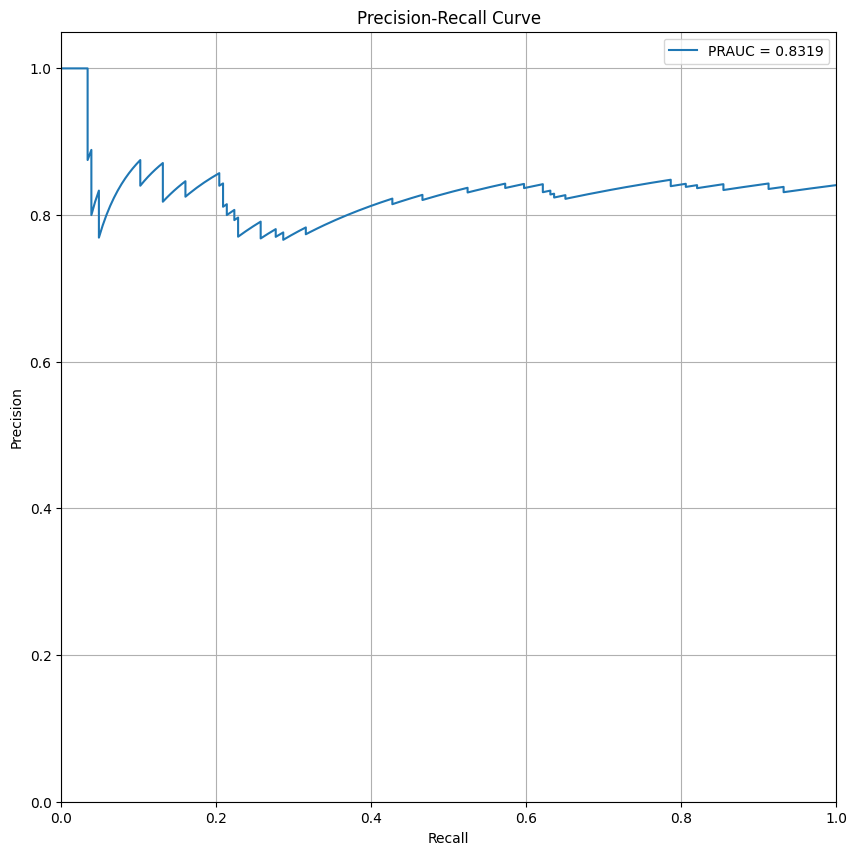

Average PR-AUC: 0.8319
Average F1 Score (threshold=0.0002): 0.9135
Precision: 0.8408
Recall: 1.0000


In [583]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from tqdm import tqdm
import itertools

class FlowGAT(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads=8, dropout=0.6):
        super(FlowGAT, self).__init__()
        
        # First GAT layer with multiple attention heads
        self.gat1 = GATConv(
            in_features, 
            hidden_features, 
            heads=num_heads, 
            dropout=dropout,
            concat=True  # Concatenate the outputs of all heads
        )
        
        # Second GAT layer with a single attention head for final prediction
        self.gat2 = GATConv(
            hidden_features * num_heads,
            out_features,
            heads=1,
            dropout=dropout,
            concat=False  # Single head output
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        """
        Forward pass through the FlowGAT model.
        
        Parameters:
        -----------
        x : torch.Tensor
            Node features
        edge_index : torch.Tensor
            Graph connectivity in COO format
        edge_weight : torch.Tensor, optional
            Edge weights
            
        Returns:
        --------
        torch.Tensor
            Output predictions (raw logits, without sigmoid)
        """
        # First GAT layer with ReLU activation
        x = self.gat1(x, edge_index, edge_weight)
        x = F.elu(x)
        x = self.dropout(x)
        
        # Second GAT layer
        x = self.gat2(x, edge_index, edge_weight)
        
        # Return raw logits (without sigmoid)
        return x

def prepare_graph_data(adjacency_matrix, fpe_features, reaction_essentiality): 
    # Use NumPy to get nonzero indices and values (efficient)
    rows, cols = np.nonzero(adjacency_matrix)  
    edge_index = torch.tensor(np.vstack((rows, cols)), dtype=torch.long)
    edge_weight = torch.tensor(adjacency_matrix[rows, cols], dtype=torch.float)

    # Convert FPE features to tensor
    x = torch.tensor(fpe_features, dtype=torch.float)

    # Create graph data object
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

    # Extract labeled nodes (excluding -1)
    labeled_indices = []
    labels = []
    
    for idx, (rxn_id, label) in enumerate(reaction_essentiality.items()):
        if label != -1:  # Only include valid labels
            labeled_indices.append(idx)
            labels.append(label)

    # Convert lists to tensors
    labeled_indices = torch.tensor(labeled_indices, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    return data, labeled_indices, labels


def prepare_graph_data_from_mfg(X_with_labels):
    # Extract features and labels from the DataFrame
    features = X_with_labels.drop('essentiality', axis=1).values
    labels_series = X_with_labels['essentiality']
    
    # Get node indices and their labels
    all_indices = np.arange(len(labels_series))
    labeled_mask = labels_series != -1
    labeled_indices = all_indices[labeled_mask]
    labels = labels_series[labeled_mask].values
    
    # Extract the original adjacency matrix from the features
    num_nodes = features.shape[0]
    adjacency_matrix = features[:, :num_nodes]  # First half contains M_k
    
    # Get edge index and weights from adjacency matrix
    rows, cols = np.nonzero(adjacency_matrix)  
    edge_index = torch.tensor(np.vstack((rows, cols)), dtype=torch.long)
    edge_weight = torch.tensor(adjacency_matrix[rows, cols], dtype=torch.float)
    
    # Convert features to tensor
    x = torch.tensor(features, dtype=torch.float)
    
    # Create graph data object
    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
    
    # Convert labeled indices and labels to tensors
    labeled_indices = torch.tensor(labeled_indices, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return data, labeled_indices, labels

def train_flowgat(data, labeled_indices, labels, hyperparams, n_splits=5, epochs=260):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)
    
    # Extract hyperparameters
    hidden_features = hyperparams['hidden_features']
    num_heads = hyperparams['num_heads']
    dropout = hyperparams['dropout']
    lr = hyperparams['lr']
    weight_decay = hyperparams['weight_decay']
    
    # Handle class imbalance
    if hyperparams.get('use_class_weights', False):
        # Calculate class weights for imbalanced dataset
        # Make sure to handle both PyTorch tensors and NumPy arrays
        if isinstance(labels, torch.Tensor):
            num_pos = torch.sum(labels == 1).item()
            num_neg = torch.sum(labels == 0).item()
        else:
            num_pos = np.sum(labels == 1)
            num_neg = np.sum(labels == 0)
        pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float).to(device)
    else:
        pos_weight = None
    
    # Convert labels to numpy for stratified split
    labeled_indices_np = labeled_indices.cpu().numpy() if isinstance(labeled_indices, torch.Tensor) else np.array(labeled_indices)
    labels_np = labels.cpu().numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Lists to store results
    models = []
    val_indices_list = []
    predictions_list = []
    true_labels_list = []
    
    # Collect training statistics
    train_stats = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(labeled_indices_np, labels_np)):
        print(f"Training fold {fold+1}/{n_splits}")
        
        # Get train and validation indices
        train_mask = labeled_indices_np[train_idx]
        val_mask = labeled_indices_np[val_idx]
        
        # Initialize model
        in_features = data.x.shape[1]
        model = FlowGAT(
            in_features=in_features, 
            hidden_features=hidden_features, 
            out_features=1,
            num_heads=num_heads,
            dropout=dropout
        ).to(device)
        
        # Initialize optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Convert labels to PyTorch tensor
        y = torch.tensor(labels_np, dtype=torch.float).to(device)
        
        # Training loop
        fold_train_loss = []
        fold_val_loss = []
        fold_val_accuracy = []
        fold_val_precision = []
        fold_val_recall = []
        fold_val_f1 = []
        
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight)
            
            # Calculate loss on training nodes (using BCE with logits since we removed sigmoid)
            if pos_weight is not None:
                loss = F.binary_cross_entropy_with_logits(
                    out[train_mask].view(-1), 
                    y[train_idx], 
                    pos_weight=pos_weight
                )
            else:
                loss = F.binary_cross_entropy_with_logits(
                    out[train_mask].view(-1), 
                    y[train_idx]
                )
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Print training progress
            if (epoch + 1) % 20 == 0:
                model.eval()
                with torch.no_grad():
                    val_out = out[val_mask].view(-1)
                    val_loss = F.binary_cross_entropy_with_logits(val_out, y[val_idx])
                    
                    # Apply sigmoid for predictions
                    val_probs = torch.sigmoid(val_out)
                    pred_binary = (val_probs > 0.5).float()
                    
                    # Calculate metrics
                    val_labels_np = y[val_idx].cpu().numpy()
                    pred_binary_np = pred_binary.cpu().numpy()
                    
                    accuracy = accuracy_score(val_labels_np, pred_binary_np)
                    
                    # Handle cases with no positive predictions or no positive labels
                    try:
                        prec = precision_score(val_labels_np, pred_binary_np)
                    except:
                        prec = 0.0
                    
                    try:
                        rec = recall_score(val_labels_np, pred_binary_np)
                    except:
                        rec = 0.0
                    
                    try:
                        f1 = f1_score(val_labels_np, pred_binary_np)
                    except:
                        f1 = 0.0
                    
                    print(f"Epoch: {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {accuracy:.4f}")
                    
                    # Store metrics
                    fold_train_loss.append(loss.item())
                    fold_val_loss.append(val_loss.item())
                    fold_val_accuracy.append(accuracy)
                    fold_val_precision.append(prec)
                    fold_val_recall.append(rec)
                    fold_val_f1.append(f1)
        
        # Store fold statistics
        train_stats['train_loss'].append(fold_train_loss)
        train_stats['val_loss'].append(fold_val_loss)
        train_stats['val_accuracy'].append(fold_val_accuracy)
        train_stats['val_precision'].append(fold_val_precision)
        train_stats['val_recall'].append(fold_val_recall)
        train_stats['val_f1'].append(fold_val_f1)
        
        # Evaluate final model
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.edge_weight)
            val_pred = torch.sigmoid(out[val_mask].view(-1)).cpu().numpy()
        
        # Store results
        models.append(model)
        val_indices_list.append(val_idx)
        predictions_list.append(val_pred)
        true_labels_list.append(y[val_idx].cpu().numpy())
    
    return models, val_indices_list, predictions_list, true_labels_list, train_stats

def evaluate_results(val_indices_list, predictions_list, true_labels_list):
   
    # Flatten predictions and labels
    all_preds = np.concatenate(predictions_list)
    all_labels = np.concatenate(true_labels_list)
    
    # Calculate PRAUC
    precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)
    pr_auc = auc(recall, precision)
    
    # Find optimal threshold based on F1 score
    f1_scores = []
    for t in thresholds:
        try:
            f1 = f1_score(all_labels, (all_preds >= t).astype(int))
            f1_scores.append(f1)
        except:
            f1_scores.append(0.0)
    
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    
    # Calculate metrics with optimal threshold
    binary_preds = (all_preds >= best_threshold).astype(int)
    f1 = f1_score(all_labels, binary_preds)
    prec = precision_score(all_labels, binary_preds)
    rec = recall_score(all_labels, binary_preds)

    '''
    # Plot precision-recall curve
    plt.figure(figsize=(10, 10))
    plt.plot(recall, precision, label=f'PRAUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('precision_recall_curve.png')
    plt.show()
    '''
    # Plot precision-recall curve
    plt.figure(figsize=(10, 10))
    plt.plot(recall, precision, label=f'PRAUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.ylim([0.0, 1.05])  # Set y-axis limits to show full [0,1] range with small margin
    plt.xlim([0.0, 1.0])   # Set x-axis limits for consistency
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Average PR-AUC: {pr_auc:.4f}")
    print(f"Average F1 Score (threshold={best_threshold:.4f}): {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    
    return pr_auc, f1, prec, rec

def grid_search_flowgat(data, labeled_indices, labels, n_splits=5, cv_epochs=140):
    # Define hyperparameter grid
    param_grid = {
        'hidden_features': [8, 16, 32],
        'num_heads': [4, 8],
        'dropout': [0.3, 0.5],
        'lr': [0.01, 0.005, 0.001,0.0005],
        'weight_decay': [5e-4, 1e-4],
        'use_class_weights': [True, False]
    }
    
    # Handle case where use_class_weights is a boolean instead of a list
    for key in param_grid:
        if not isinstance(param_grid[key], list):
            param_grid[key] = [param_grid[key]]
    
    # Choose a subset of hyperparameter combinations to test
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combinations = list(itertools.product(*values))
    
    # Sample combinations if there are too many
    max_combinations = 12  # Adjust based on your computational resources
    if len(combinations) > max_combinations:
        np.random.seed(42)
        indices = np.random.choice(len(combinations), max_combinations, replace=False)
        combinations = [combinations[i] for i in indices]
    
    # Initialize results tracking
    results = []
    best_prauc = 0.0
    best_params = None
    
    # Iterate through parameter combinations
    for i, params in enumerate(combinations):
        hyperparams = {keys[j]: params[j] for j in range(len(keys))}
        print(f"\nHyperparameter combination {i+1}/{len(combinations)}:")
        print(hyperparams)
        
        # Train and evaluate model with current hyperparameters
        models, val_indices_list, predictions_list, true_labels_list, _ = train_flowgat(
            data, 
            labeled_indices, 
            labels, 
            hyperparams, 
            n_splits=n_splits, 
            epochs=cv_epochs
        )
        
        # Evaluate model
        pr_auc, f1, precision, recall = evaluate_results(val_indices_list, predictions_list, true_labels_list)
        
        # Store results
        result = {
            **hyperparams,
            'prauc': pr_auc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }
        results.append(result)
        
        # Update best parameters
        if pr_auc > best_prauc:
            best_prauc = pr_auc
            best_params = hyperparams
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by PR-AUC
    results_df = results_df.sort_values('prauc', ascending=False).reset_index(drop=True)
    
    print("\nGrid Search Results:")
    print(results_df.head())
    
    print("\nBest Hyperparameters:")
    print(best_params)
    print(f"Best PR-AUC: {best_prauc:.4f}")
    
    # Save results to CSV
    results_df.to_csv('grid_search_results.csv', index=False)
    
    return best_params, best_prauc, results_df

def train_and_evaluate_final_model(data, labeled_indices, labels, best_params, n_splits=5, epochs=260):
    # Train final model with best hyperparameters
    models, val_indices_list, predictions_list, true_labels_list, train_stats = train_flowgat(
        data, 
        labeled_indices, 
        labels, 
        best_params, 
        n_splits=n_splits, 
        epochs=epochs
    )
    
    # Evaluate final model
    pr_auc, f1, precision, recall = evaluate_results(val_indices_list, predictions_list, true_labels_list)
    
    # Compile metrics
    metrics = {
        'prauc': pr_auc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    # Plot training curves
    plot_training_curves(train_stats)
    
    return models, metrics, train_stats

def predict_with_flowgat(models, data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.to(device)
    
    # Make predictions with each model
    all_preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            # Get raw logits and apply sigmoid
            logits = model(data.x, data.edge_index, data.edge_weight).view(-1)
            pred_probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(pred_probs)
    
    # Average predictions
    ensemble_preds = np.mean(all_preds, axis=0)
    binary_preds = (ensemble_preds >= 0.5).astype(int)
    
    #return ensemble_preds
    

    return ensemble_preds, binary_preds

if __name__ == "__main__":
    data, labeled_indices, labels = prepare_graph_data_from_mfg(X_with_labels)
    #data, labeled_indices, labels = prepare_graph_data_from_mfg(bacillus)

    
    #best_params, best_prauc, results_df = grid_search_flowgat(data, labeled_indices, labels)
    
    # Example of training final model
    
    models, metrics, train_stats = train_and_evaluate_final_model(data, labeled_indices, labels, best_params)

    ensemble_predictions = predict_with_flowgat(models, data)

In [578]:
ensemble_predictions = ensemble_predictions[0]

In [581]:
prediction_df = pd.DataFrame({
    'node_index': range(len(ensemble_predictions)),
    'prediction_score': ensemble_predictions,
    'predicted_class': (ensemble_predictions >= 0.6).astype(int)
})

# Add actual labels for nodes that have them
labeled_indices_np = np.array(labeled_indices)
labels_np = np.array(labels)
for i, idx in enumerate(labeled_indices_np):
    prediction_df.loc[prediction_df['node_index'] == idx, 'true_label'] = labels_np[i]

# Calculate error type (FP, FN, TP, TN)
prediction_df['error_type'] = prediction_df.apply(
    lambda row: 'Unknown' if pd.isna(row['true_label']) else
    ('TP' if row['predicted_class'] == 1 and row['true_label'] == 1 else
     'TN' if row['predicted_class'] == 0 and row['true_label'] == 0 else
     'FP' if row['predicted_class'] == 1 and row['true_label'] == 0 else 'FN'),
    axis=1
)

C:\Users\Miki\AppData\Local\Temp\ipykernel_36912\3071015392.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labeled_indices_np = np.array(labeled_indices)
C:\Users\Miki\AppData\Local\Temp\ipykernel_36912\3071015392.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_np = np.array(labels)


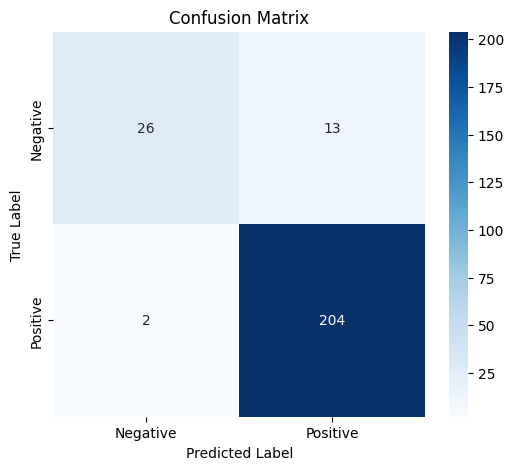

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78        39
           1       0.94      0.99      0.96       206

    accuracy                           0.94       245
   macro avg       0.93      0.83      0.87       245
weighted avg       0.94      0.94      0.93       245



In [582]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Remove rows where 'true_label' is NaN (they are not part of the evaluation)
filtered_df = prediction_df.dropna(subset=['true_label']).copy()

# Ensure 'true_label' and 'predicted_class' are integers
filtered_df['true_label'] = filtered_df['true_label'].astype(int)
filtered_df['predicted_class'] = filtered_df['predicted_class'].astype(int)

# Compute confusion matrix
cm = confusion_matrix(filtered_df['true_label'], filtered_df['predicted_class'])

# Define labels for the confusion matrix
labelss = ["Negative", "Positive"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labelss, yticklabels=labelss)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(filtered_df['true_label'], filtered_df['predicted_class']))


In [504]:
bacillus = pd.read_csv('Y_with_labels.csv', index_col=0)

In [505]:
bacillus

,outflow_EX_ca2_e_forward,outflow_EX_ca2_e_reverse,outflow_EX_so4_e_forward,outflow_EX_so4_e_reverse,outflow_EX_co2_e_forward,outflow_EX_h2o_e_forward,outflow_EX_h2o_e_reverse,outflow_EX_h_e_forward,outflow_EX_h_e_reverse,outflow_2S6HCCi_forward,...,inflow_KAS6_forward,inflow_KAS6_reverse,inflow_KAS11_forward,inflow_KAS11_reverse,inflow_PGMT_forward,inflow_RNDR3_forward,inflow_TECA3S45_reverse,inflow_PGM_reverse,inflow_PHCYT_BS_forward,essentiality
EX_ca2_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
EX_ca2_e_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
EX_so4_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
EX_so4_e_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
EX_co2_e_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001449,0.001449,0.001734,0.001864,0.0,0.0,0.0,0.000000,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PGMT_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1
RNDR3_forward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
TECA3S45_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
PGM_reverse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1


In [480]:
X_with_labels

,outflow_SHK3Dr_forward,outflow_DHORTS_forward,outflow_DHORTS_reverse,outflow_OMPDC_forward,outflow_OMPDC_reverse,outflow_G5SD_forward,outflow_G5SD_reverse,outflow_CS_reverse,outflow_ICDHyr_forward,outflow_ICDHyr_reverse,...,inflow_APG3PAT160_forward,inflow_APG3PAT160_reverse,inflow_APG3PAT161_forward,inflow_APG3PAT161_reverse,inflow_MEOHtex_forward,inflow_I2FE2SS_forward,inflow_I2FE2SS2_reverse,inflow_DM_4crsol_c_reverse,inflow_THZPSN3_reverse,essentiality
SHK3Dr_forward,0.000000,0.000000,0.000000,0.0,0.475359,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-1
DHORTS_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
DHORTS_reverse,0.000000,0.000000,0.000000,0.0,0.275716,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
OMPDC_forward,0.258708,0.286727,0.258708,0.0,0.000000,0.0,0.258708,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
OMPDC_reverse,7.193559,0.000000,7.193559,0.0,0.000000,0.0,7.193559,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEOHtex_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-1
I2FE2SS_forward,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-1
I2FE2SS2_reverse,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-1
DM_4crsol_c_reverse,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.808708,0.0,0.0,-1


In [502]:
bacillus = bacillus.iloc[1:, 1:]  # Keep all rows, all columns except first

In [503]:
bacillus

,outflow_EX_ca2_e_reverse,outflow_EX_so4_e_forward,outflow_EX_so4_e_reverse,outflow_EX_co2_e_forward,outflow_EX_h2o_e_forward,outflow_EX_h2o_e_reverse,outflow_EX_h_e_forward,outflow_EX_h_e_reverse,outflow_2S6HCCi_forward,outflow_2S6HCCi_reverse,...,inflow_KAS6_forward,inflow_KAS6_reverse,inflow_KAS11_forward,inflow_KAS11_reverse,inflow_PGMT_forward,inflow_RNDR3_forward,inflow_TECA3S45_reverse,inflow_PGM_reverse,inflow_PHCYT_BS_forward,essentiality
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001449,0.001449,0.001734,0.001864,0.0,0.0,0.0,0.000000,0.0,-1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1
328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1
